# Random Circle Generator Algorithm
## Description
This code generates random distriubtion of circles within a specified domain such that:

* The distribution of circles nearest neighbor distances (NNDs) matches with a specified target distribution. The target distributions for the circles NNDs is Weibull, with parameters specified by the user.

* the circles are not allowed to intersect.

* The sizes of the circles can be different. In this code, the radii of the circles are random, drawn from a normal distribution.

>> **Note**: If the circles are to have the same size, a small value can be selected for the starndard deviation in the normal distribution.

* A minimum allowable value for the circles' NND can be specified.

## Algorithm Summary

* **Step 1:** Uniformly distribute the circles within the domain.
* **Step 2:** Shuffle the circles within the domain.
* **Step 3:** Adjust the distribution of circles' NND based on the target distribution.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min
import time

## Input Parameters

Eah circle is initially placed at the center of cell; a square with specified dimention.

In [2]:
#Input parameters
width = 107 #domain x
height = 107 #domain y

cell_dim = 7.6 #dimension of the cells which the circles are initially placed at the center
R_mean = 3.5 #circles mean radius
R_std = 0.000000001 #standard deviation of circles radius
min_circle_dist = 0.0 #minimum allowable NND for the circles

#Calculate the distribution of Circles NNDs from a Weibull distribution
#--> target distribution for the circles NNDs
Weibull_shape = 0.65
Weibull_scale = 0.08

# Helper Functions

Now we define a number of functions that we are going to utilize in this algorithm.

## Distance Matrix

We define a distance matrix $D$, a square symmetrical array with a size of $n_{circles} \times n_{circles}$, where $n_{circles}$ is the total number of circles withing the domain. Each element of this matrix, $D_{ij}$, is the **clear distance** between the $i_{th}$ circle and the $j_{th}$ circle in the domain.

**Note:** The distance matrix is calculated without any $``for"$ loop to reduce the time complexity of the computation.

In [3]:
#Distance matrix without for loop
def Distance_Matrix(Circle, Radiuss):
    D_x = -2*np.dot(Circle[:,0][:,np.newaxis],Circle[:,0][np.newaxis,:])+Circle[:,0][:,np.newaxis]**2+Circle[:,0][np.newaxis,:]**2
    D_y = -2*np.dot(Circle[:,1][:,np.newaxis],Circle[:,1][np.newaxis,:])+Circle[:,1][:,np.newaxis]**2+Circle[:,1][np.newaxis,:]**2
    D = np.sqrt(D_x+D_y) - Radiuss[np.newaxis,:] - Radiuss[:,np.newaxis]
    np.fill_diagonal(D, 1e10)
    min_D = np.min(D,axis=0)
    return D, min_D

## Kullback–Leibler Divergence

The similarity between the circles' NNDs distribution of the generated circles and the target distributoin is measured using [Kullback-Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). The KL divergence for two discrete probability distributions P and Q defined on the same probability space $\mathcal{X}$ is calculated as:

$$D_{KL}(P||Q)=\sum_{x \in \mathcal{X}}P(x)log\left(\frac{P(x)}{Q(x)}\right)$$

In [4]:
def KL_Divergence(dist1,dist2,start_point, end_point, n_bins):    
    bin_length = (end_point-start_point)/n_bins
    edges = np.arange(start_point, end_point, bin_length)
    hist1 = np.histogram(dist1,edges)[0]/np.shape(dist1)[0]
    hist2 = np.histogram(dist2,edges)[0]/np.shape(dist2)[0]
    hist1[hist1==0] = 1e-5 #to avoid division by 0 
    hist2[hist2==0] = 1e-5 #to avoid division by 0
    KL = np.dot(hist1,np.log(hist1/hist2))
    return KL

## Weibull Distribution

The probability density function (PDF) for the Weibull distribution.

In [5]:
def Weibull_dist(shape,scale,start_point, end_point, n_points):
    size = (end_point-start_point)/n_points
    x = np.arange(start_point, end_point, size)
    PDF_dist = shape/scale*((x/scale)**(shape-1))*(np.e**(-(x/scale)**shape))
    return PDF_dist

## CDF Plot

Simultaneous plot of two cumulative distribution functions based on two discrete input vectors.

In [6]:
def CDF_plots(data1,data2):
    # Data1:
    data1 = np.append(data1,0)
    sorted_data1 = np.sort(data1)
    CDF1 = np.arange(np.size(sorted_data1))
    CDF1 = CDF1/np.max(CDF1)
    # Data2:
    data2 = np.append(data2,0)
    sorted_data2 = np.sort(data2)
    CDF2 = np.arange(np.size(sorted_data2))
    CDF2 = CDF2/np.max(CDF2)
    plt.plot(sorted_data1, CDF1,sorted_data2, CDF2)
    plt.legend(('Target distribution', 'Generated distribution'),fontsize='x-large')
    plt.show()    

## **Step 1:** Initial uniform circle placement
Arrange the cells that contain the circles in a regular order, with a staggering pattern. The neighboring cells touch one another. The initial distances between the neighboring circles is controlled using the cells dimentions.

In [7]:
y = 0
counter_y = 0
n_circles=1;
Circ_loc = np.empty((0,2), float)
Radius = np.array([])
pi = 3.14159265358
while (y+3*cell_dim/2 <= height):
    y = cell_dim/2+counter_y*cell_dim
    counter_y = counter_y+1
    counter_x = 0
    x = 0
    while (x+3*cell_dim/2 <= width):
        Radius = np.append(Radius, np.random.normal(R_mean, R_std))
        if (counter_y%2==0): #even rows
            x = cell_dim + counter_x*cell_dim
        else: #odd rows
            x = cell_dim/2 + counter_x*cell_dim
        counter_x = counter_x+1
        Circ_loc = np.append(Circ_loc, np.array([[x, y]]), axis=0)
        n_circles=n_circles+1
# calculating the volume fraction of circles
area1 = height*width
area2 = np.sum(pi*Radius**2)
print('Circles volume fraction  = ',100*area2/area1,'%',sep='')

Circles volume fraction  = 63.53019819254121%


Plot the initial randomly arranged circles within the domain.

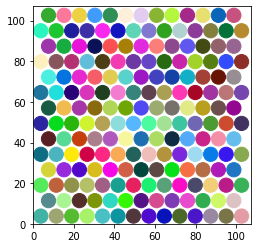

In [8]:
fig, ax = plt.subplots()
for i in range(Radius.shape[0]):
    circle_color=(np.random.random(), np.random.random(), np.random.random())
    circle = plt.Circle((Circ_loc[i,]), Radius[i], color=circle_color)
    ax.add_artist(circle)
ax.set_xlim((0, width))
ax.set_ylim((0, height))
# fig.set_size_inches(5,5)
plt.gca().set_aspect(1)

Compare the initial distribution with the target Weibull distribution:

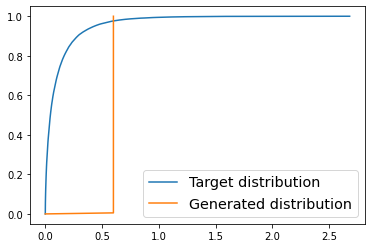

In [9]:
n = 50000   # number of samples from the Weibull distribution
#Initial distance matrix
Distance,NN_distance = Distance_Matrix(Circ_loc,Radius)
#Target Weibull distribution 
NN_distance_target = weibull_min.rvs(Weibull_shape, loc=0, scale=Weibull_scale, size=n)
#Plot both distributions
CDF_plots(NN_distance_target,NN_distance)

Calculate initial KL divergence

In [10]:
KL = KL_Divergence(NN_distance_target,NN_distance,0,2,30)
print('Initial KL divergence = ',KL)

Initial KL divergence =  9.904920321657817


## **Step 2:** Shuffle the circles in the domain

In this step, we randomly select a circle and apply a random perturbation to it. If the circle does not interset with other circles, the perturbation is accepted. This process is repeated over and over until there is a specific number of accepted perturbations (counter_final). After this step, the circle in the domain are completely shuffled and are not uniformly distributed anymore.

In [11]:
counter_final = 10000 #required number of accepted perturbations
counter = 0

while (counter < counter_final):    
    sigma = np.random.random_sample()
    #randomly select one circle
    j = np.random.randint(np.shape(Radius)[0])
    #randomly choose a perturbation
    Xr = np.random.normal(0.0, sigma)
    Yr = np.random.normal(0.0, sigma)
    #add perturbation
    Circ_loc[j,0] = Circ_loc[j,0]+Xr
    Circ_loc[j,1] = Circ_loc[j,1]+Yr
    #check if there is any intersection between the perturbed circle and
    #boundaries/other circles
    Distance,NN_distance = Distance_Matrix(Circ_loc, Radius)
    n_circ_int = np.sum((Distance-min_circle_dist)<0)
    counter = counter+1
    if (n_circ_int>0 or  Circ_loc[j,0]>(width - Radius[j]) or Circ_loc[j,1]>(height - Radius[j]) or Circ_loc[j,0]< Radius[j] or Circ_loc[j,1]<Radius[j]):
        Circ_loc[j,0] = Circ_loc[j,0]-Xr
        Circ_loc[j,1] = Circ_loc[j,1]-Yr
        counter = counter-1
    if (counter%(counter_final/100)==0):
        print('\r','Initial shuffling progress = ',counter*100/counter_final,'%',sep='', end='')

Initial shuffling progress = 100.0%

## **Step 3:** Modify the distribution of circles NNDs

The algorithm in this step modifies the distribution of the circles NNDs so that it matches with the target Weibull distribution. This step is similar to Step 2 with one more condition; a circle is randomly selected subjected to a random perturbation. If the circle does not intersect with other circles **and** if the perturbation improves the distribution of circles NNDs, the perturbation is accepted. The similarity between the circles' distribution and the target distribution is measured using the KL divergence. This process is repeated over and over for a specific amount of time until the distribution is no longer improved. The specific amount of time is a user-defined parameter and depends on the number of circles in the domain.

 Accepted perturbations =  131 ----> KL divergence =  0.018806719255715008

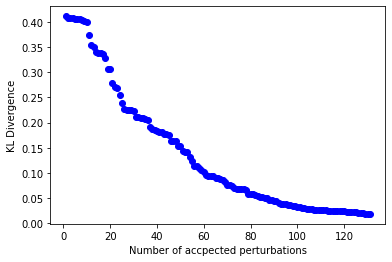

In [12]:
current_time = time.time()
iteration_time=60 #this time depends on the number of circles in the domain
final_time = current_time+60
fig = plt.gcf()
fig.show()
fig.canvas.draw()
step_couter = 1
while (current_time < final_time):
    current_time = time.time()
    sigma = np.random.random_sample()
    accept_perturbation = True
    #randomly select one circle
    j = np.random.randint(np.shape(Radius)[0])
    #randomly choose a perturbation
    Xr = np.random.normal(0.0, sigma)
    Yr = np.random.normal(0.0, sigma)
    #add perturbation
    Circ_loc[j,0] = Circ_loc[j,0]+Xr
    Circ_loc[j,1] = Circ_loc[j,1]+Yr
    #check if there is any intersection between the perturbed circle and
    #boundaries/other circles
    Distance,NN_distance = Distance_Matrix(Circ_loc, Radius)
    n_circ_int = np.sum((Distance-min_circle_dist)<0)
    counter = counter+1
    if (n_circ_int>0 or  Circ_loc[j,0]>(width - Radius[j]) or Circ_loc[j,1]>(height - Radius[j]) or Circ_loc[j,0]< Radius[j] or Circ_loc[j,1]<Radius[j]):
        accept_perturbation = False
        Circ_loc[j,0] = Circ_loc[j,0]-Xr
        Circ_loc[j,1] = Circ_loc[j,1]-Yr
    #the distributions distance is calculated only when there is no penetration!
    if (accept_perturbation): 
        new_KL = KL_Divergence(NN_distance_target,NN_distance,0,2,30)
        Delta = new_KL - KL
        if (Delta<0):
            KL = new_KL
            plt.plot(step_couter,KL,'bo')
            plt.ylabel('KL Divergence')
            plt.xlabel('Number of accpected perturbations')
            fig.canvas.draw()
            print('\r','Accepted perturbations = ',step_couter, '---->','KL divergence = ',KL, end='')
            step_couter=step_couter+1
        else:
            Circ_loc[j,0] = Circ_loc[j,0]-Xr
            Circ_loc[j,1] = Circ_loc[j,1]-Yr

Now we can plot the distributions together:

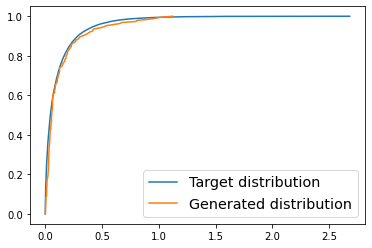

In [13]:
CDF_plots(NN_distance_target,NN_distance)

And finally, we can plot the resulting randomly distributed circles

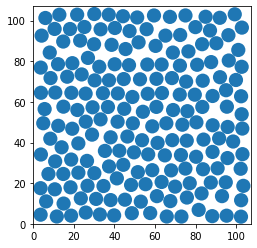

In [14]:
fig, ax = plt.subplots()
for i in range(Radius.shape[0]):
    circle_color=(np.random.random(), np.random.random(), np.random.random())
    circle = plt.Circle((Circ_loc[i,]), Radius[i])
    ax.add_artist(circle)
ax.set_xlim((0, width))
ax.set_ylim((0, height))
# fig.set_size_inches(5,5)
plt.gca().set_aspect(1)